In [1]:
'''
'''
from PyInventor import *
import numpy as np
from numpy import pi, cos, sin, sqrt, log
import math
import glob
import time
import datetime

#Import plotting libraries for later
import matplotlib
from matplotlib import pyplot as plt

from matplotlib import cm
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm 
from matplotlib.ticker import MaxNLocator

import pandas as pd

import pyEPR
from pyEPR import ansys as HFSS
from pyEPR.core_distributed_analysis import CalcObject

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity
import os
import re as regex

# Field integrals code
import sys
sys.path.append('../python/src')
import field_integrals as fint

In [2]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

In [3]:
def plot_2d_cmap(x, y, z, fname,                                                
                 xstr='', ystr='',                                              
                 tstr='', cbar_str='',                                          
                 cmap=cm.viridis,
                 xyscales={'x' : 'linear', 'y': 'linear'},
                 interp_zeros=False,
                interp_std_dev=10,
                image_rot_angle=0,
                xrot_angle=None,
                norm_type='linear',
                zref=None, 
                fsize=30,
                tsize=36):
    """                                                                         
    Plot 2D colormap data such that                                             
                                                                                
         -----------------------                                                
         |                     |                                                
         |                     |                                                
    y    |          z          |                                                
         |                     |                                                
         |                     |                                                
         -----------------------                                                
                                                                                
                    x                                                           
                                                                                
    Parameters:                                                                 
    ----------                                                                  
                                                                                
    x, y:       independent variables                                           
    z:          resulting data, z = z(x, y)                                     
    fname:      output figure filename, relative path with file extension       
    xstr:       x-axis label                                                    
    ystr:       y-axis label                                                    
    tstr:       title label                                                     
    cbar_str:   lable for color bar                                             
    cmap:       colormap to use on the 2D figure output                         
                                                                                
    """
    # Interpolate the data
    if interp_zeros:
        hot_pixels, z = fix_outlier_pixels(z, tolerance=interp_std_dev)
    
    # Setup the color map, normalizations, etc
    if norm_type == 'linear':
        norm = mpl.colors.Normalize(z.min(), z.max())
    elif norm_type == 'log':
        if zref:
            norm = mpl.colors.LogNorm(min(zref), max(zref))
        else:
            norm = mpl.colors.Normalize(min(zref), max(zref))    
    elif (norm_type == 'ref') and zref:
        norm = mpl.colors.Normalize(min(zref), max(zref))
    else:
        raise ValueError(f'norm_type ({norm_type}) not recognized')                                         
                                                                                
    # Setup the figure and axes                                                 
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
    
    # Set the scale bar and levels
    if (norm_type == 'ref') and zref:
        levels = MaxNLocator(nbins=20).tick_values(min(zref), max(zref))
    else:
        levels = MaxNLocator(nbins=20).tick_values(z.min(), z.max())
    if image_rot_angle:
        z = scipy.ndimage.rotate(z, image_rot_angle, reshape=True)
    #plt1 = ax.imshow(z, cmap=cmap, norm=norm)
    plt1 = ax.pcolormesh(x, y, z, cmap=cmap, norm=norm)
    ax.set_xlabel(xstr, fontsize=fsize)                                         
    ax.set_ylabel(ystr, fontsize=fsize)                                         
    ax.set_title(tstr, fontsize=tsize)
    
    # Rotate the xlabels. Set both x and y labels to headers[1:]
    ax.set_xscale(xyscales['x'])
    ax.set_yscale(xyscales['y'])
    if xrot_angle is not None:
        set_xaxis_rot(ax, xrot_angle)
                                                                                
    # Set the axis tick labels to a reasonable size                             
    set_axes_fonts(ax, fsize)                                                   
                                                                                
    # Set the color bar, offset the title slightly from top                     
    cbar = fig.colorbar(plt1, ax=ax)                                            
    cbar.ax.set_title(cbar_str, fontsize=fsize, y=1.025)                        
    cbar.ax.tick_params(labelsize=fsize)                                        
                                                                                
    # Write the results to file
    print(f'Writing {fname} ...')
    fig.savefig(fname, format='pdf', transparent=True)                  

## Read the eigenmode data from file, compute the level splitting, plot vs. the two parameters

In [9]:
data = np.genfromtxt('../data/modes_vs_zoffset_rtunnel_simple_posts_0p01_error_240328.csv', names=True, delimiter=',')

In [10]:
r_tunnel = np.unique(data['r_tunnel_mm'])
z_tunnel_offset = np.unique(data['z_tunnel_offset_mm'])
mode_splittings = np.reshape(data['reMode2_'] - data['reMode1_'], [r_tunnel.size, z_tunnel_offset.size])

In [11]:
mode_splittings.shape

(9, 11)

Writing ../figs/simple_post_cavity_rtunnel_zoffset_splittings.pdf ...


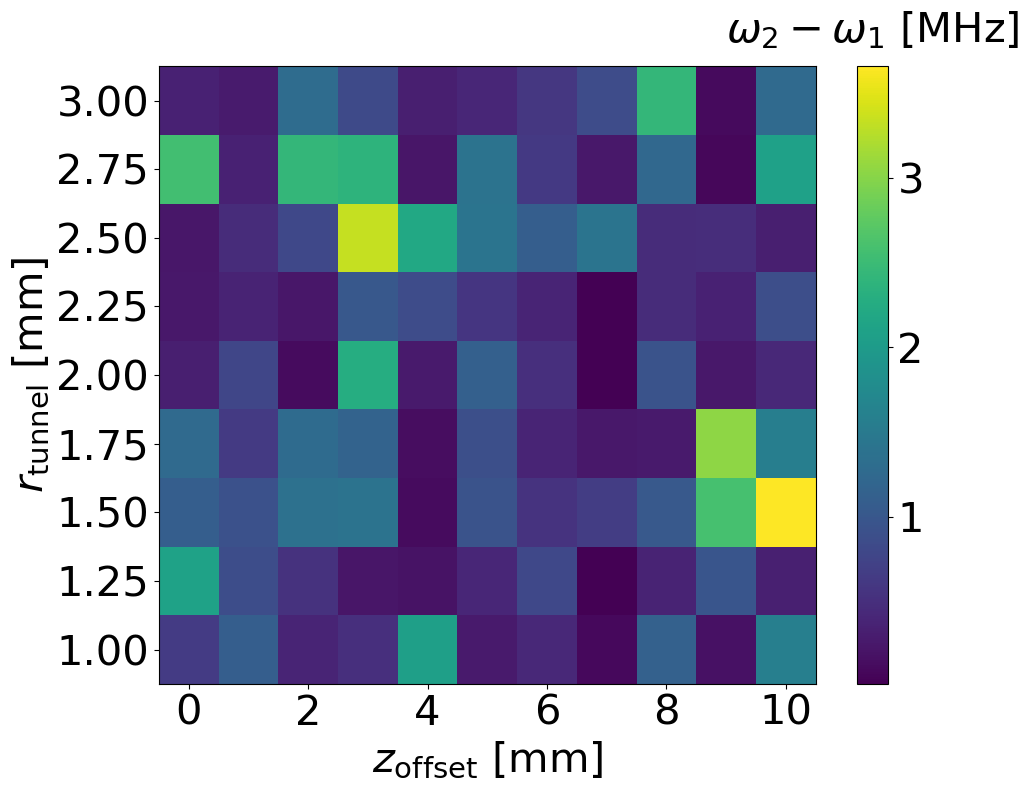

In [12]:
fname = '../figs/simple_post_cavity_rtunnel_zoffset_splittings.pdf'
plot_2d_cmap(z_tunnel_offset,
             r_tunnel,
             mode_splittings / 1e6,
             fname,
             ystr=r'$r_{\mathrm{tunnel}}$ [mm]',
             xstr=r'$z_{\mathrm{offset}}$ [mm]',
             cbar_str=r'$\omega_{2}-\omega_{1}$ [MHz]')

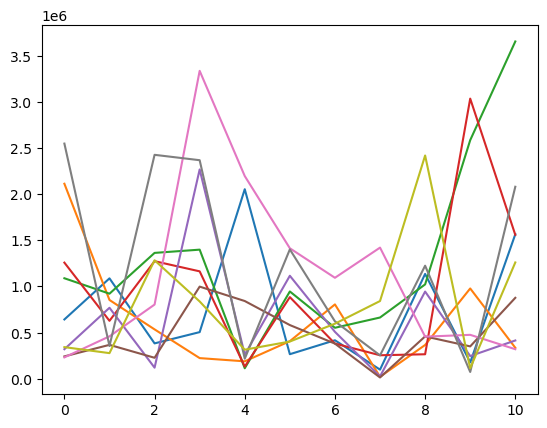

In [13]:
for k in range(r_tunnel.size):
    plt.plot(z_tunnel_offset, mode_splittings[k, :])